### Import packages

In [1]:
    include("fwmodule.jl")    
    using Pkg
    using .FWmodule
    using DifferentialEquations
    using DiffEqFlux
    using OrdinaryDiffEq
    using Lux
    using Optim
    using GalacticOptim
    using Optimization
    using ComponentArrays
    using DiffEqSensitivity
    using Flux.Losses: mae, mse, logitcrossentropy
    using LinearAlgebra
    using DelimitedFiles
    using Random
    using Statistics
    using Plots
    gr()
    using Optimization, OptimizationOptimisers, OptimizationOptimJL
    using SBMLToolkit, ModelingToolkit
    using Catalyst, Latexify
    using DynamicHMC
    using Turing

    Updating registry at `C:\Users\marce\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\marce\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes t

### Import SBML model

In [2]:
filepath = "model.sbml"
lvl = 2
version = 4
mdl = FWmodule.import_sbml(filepath, lvl, version)

SBML.Model with 2 reactions, 7 species, and 6 parameters.

In [3]:
# Define Reactions system, ODE system, Reactions vector, Species vector and ODE Functions
rs, odesys, reactionsvector, speciesvector, ode_func = FWmodule.define_model(mdl);
speciesvector

┌ Warning: SBMLToolkit currently fires events regardless of uppass or downpass trigger.
└ @ SBMLToolkit C:\Users\marce\.julia\packages\SBMLToolkit\L2qXg\src\events.jl:28


7-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 Species0(t)
 Species1(t)
 Species6(t)
 Species3(t)
 Species2(t)
 Species7(t)
 Species4(t)

In [4]:
rs

Model ##SBML#526
States (7):
  Species0(t) [defaults to 2.5e-5]
  Species1(t) [defaults to 0.0]
  Species6(t) [defaults to 0.0]
  Species3(t) [defaults to 0.0]
  Species2(t) [defaults to 0.0]
  Species7(t) [defaults to 0.0]
⋮
Parameters (7):
  Reaction0_Km [defaults to 0.0007]
  Reaction1_A
  Reaction1_Km [defaults to 0.0002]
  Reaction0_A
  Reaction0_Vmax [defaults to 2.23333e-7]
  Reaction1_Vmax [defaults to 5.0e-7]
⋮

┌ Warning: Latexify currently ignores constraint equations.
└ @ Catalyst C:\Users\marce\.julia\packages\Catalyst\S5Um3\src\latexify_recipes.jl:105


In [5]:
odesys

Model ##SBML#526 with 7 equations
States (7):
  Species0(t) [defaults to 2.5e-5]
  Species1(t) [defaults to 0.0]
  Species6(t) [defaults to 0.0]
  Species3(t) [defaults to 0.0]
  Species2(t) [defaults to 0.0]
  Species7(t) [defaults to 0.0]
⋮
Parameters (7):
  Reaction0_Km [defaults to 0.0007]
  Reaction1_A
  Reaction1_Km [defaults to 0.0002]
  Reaction0_A
  Reaction0_Vmax [defaults to 2.23333e-7]
  Reaction1_Vmax [defaults to 5.0e-7]
⋮

In [6]:
reactionsvector 

2-element Vector{Reaction}:
 (Reaction1_A*Reaction1_Vmax) / (Reaction1_A + Reaction1_Km), Species1 + Species6 ⇒ Species7 + Species3 + Species4
 (Reaction0_A*Reaction0_Vmax) / (Reaction0_A + Reaction0_Km), Species0 + Species1 ⇒ Species2 + Species3 + Species4

In [7]:
speciesvector 

7-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 Species0(t)
 Species1(t)
 Species6(t)
 Species3(t)
 Species2(t)
 Species7(t)
 Species4(t)

In [8]:
ode_func

(::ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#486"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x9bc23ed8, 0x1da1d7cc, 0xc5495fc0, 0xd5b81b3a, 0x0b4e7d44)}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xf749e5ea, 0x712db876, 0x031fb160, 0x1f63cd1d, 0x9b7bca85)}}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Vector{Symbol}, Symbol, Vector{Symbol}, ModelingToolkit.var"#498#generated_observed#494"{Bool, ODESystem, Dict{Any, Any}}, Nothing, ODESystem}) (generic function with 1 method)

In [9]:
# Setting the initial concentrations
u0 = zeros(7)
u0[1] = 10.0;      # Species0
u0[2] = 5.0;       # Species1 
u0[3] = 8.0;       # Species6
u0[4] = 0.0;       # Species3
u0[5] = 0.0;       # Species2
u0[6] = 0.0;       # Species7
u0[7] = 0.0;      # Species4

# Selected Species
selected_species = [1, 2, 3, 4, 5, 6, 7];

In [10]:
len_param = length(reactionparams(rs))
paramsvector = reactionparams(rs)[1:len_param-1]

6-element Vector{Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 Reaction0_Km
 Reaction1_A
 Reaction1_Km
 Reaction0_A
 Reaction0_Vmax
 Reaction1_Vmax

In [11]:
# Define Params (based on the SBML file information and the order from the last block)
# Obs: value '0.0' cause posterior errors if in any parameter variable, substitute it with 0.1 if necessary
#                       0_km,   1_A, 1_km,   0_A,       0_Vmax,      1_Vmax
#model_param = Float32.([0.0007, 1, 0.0002, 1, 0.0000002233333, 0.0000005]);
model_param = Float32.([0.7, 1, 0.2, 1, 0.2233333, 0.5]);

In [12]:
# Generating the time series with a simulation 
tspan = (0.0f0, 10.0f0); method = Rosenbrock23();
abstol= 1e-12; reltol=1e-6; saveat = 0.1;
X, t = FWmodule.gen_timeseries(tspan, odesys, u0, model_param, method, abstol, reltol, saveat);

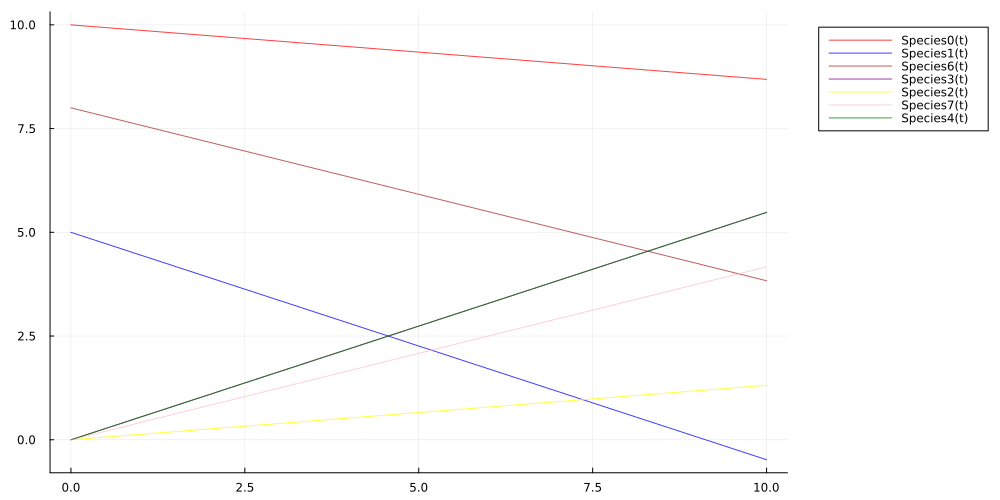

In [13]:
# Plotting
default(size = (1000, 500))
plot(
    t, X', alpha=0.75, 
    legend=:outertopright,
    labels=permutedims(speciesvector),
    ls=permutedims([:solid,:solid,:solid,:solid,:solid,:solid,:solid]),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green])
)

### Import the cutout model

In [14]:
# Import cutout model
mdl2 = FWmodule.import_sbml("cutmodel.sbml", 2, 4)

SBML.Model with 1 reactions, 7 species, and 3 parameters.

In [15]:
# Generate reaction 
rs2, odesys2, reactionsvector2, speciesvector2, ode_func2 = FWmodule.define_model(mdl2);
speciesvector2

┌ Warning: SBMLToolkit currently fires events regardless of uppass or downpass trigger.
└ @ SBMLToolkit C:\Users\marce\.julia\packages\SBMLToolkit\L2qXg\src\events.jl:28


7-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 Species0(t)
 Species1(t)
 Species6(t)
 Species3(t)
 Species2(t)
 Species7(t)
 Species4(t)

In [16]:
u0_2 = zeros(7)
u0_2[1] = 10.0;      # Species0
u0_2[2] = 5.0;       # Species1 
u0_2[3] = 8.0;       # Species6
u0_2[4] = 0.0;       # Species3
u0_2[5] = 0.0;       # Species2
u0_2[6] = 0.0;       # Species7
u0_2[7] = 0.0;      # Species4

selected_species2 = [1, 2, 3, 4, 5, 6, 7];

In [17]:
len_param2 = length(reactionparams(rs2))
paramsvector2 = reactionparams(rs2)[1:len_param2-1]

3-element Vector{Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 Reaction1_A
 Reaction1_Km
 Reaction1_Vmax

In [18]:
# Params
## Obs: value '0.0' cause posterior errors if in any parameter variable, substitute it with 0.1 if necessary
#                        1_A,  1_Km,    1_Vmax
#model_param2 = Float32.([0.1, 0.0002, 0.0000005]);
model_param2 = Float32.([0.1, 0.2, 0.5]);

In [19]:
# Generating the time series with a simulation
tspan2 = (0.0f0, 10.0f0);
method2 = Rosenbrock23();
abstol2= 1e-12; reltol2=1e-6; saveat2 = 0.1;
X_2, t_2 = FWmodule.gen_timeseries(tspan2, odesys2, u0_2, model_param2, method2, abstol2, reltol2, saveat2);

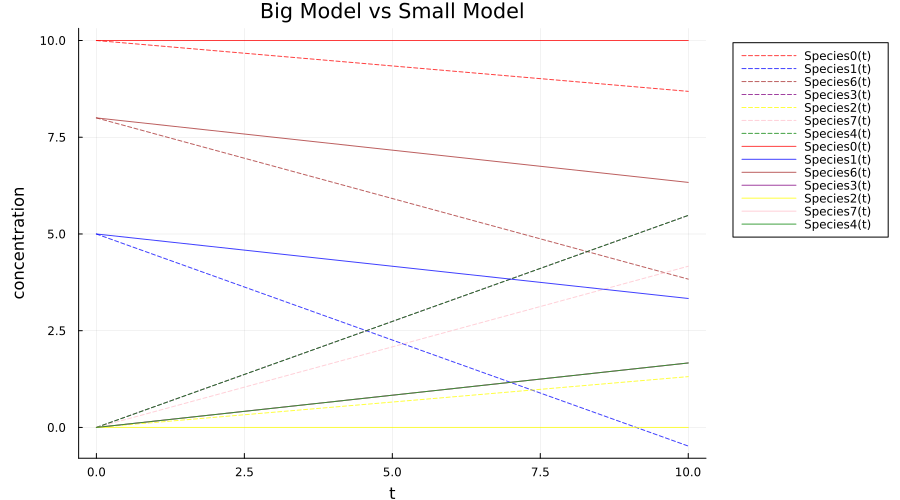

In [20]:
# Plotting
default(size = (900, 500));
plot(
    t, 
    X'[:, selected_species],
    alpha=0.75, legend=:outertopright,
    labels=permutedims(speciesvector),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green]),
    ls=:dash,
)
xlabel!("t")
ylabel!("concentration")
plot!(
    t_2, 
    X_2'[:, selected_species2],
    title="Big Model vs Small Model",
    alpha=0.75, legend=:outertopright,
    labels=permutedims(speciesvector2),
    color=permutedims([:red, :blue, :brown, :purple, :yellow, :pink, :green]),
    left_margin=5Plots.mm
)

### Turning ODE's into a system of UDE's

In [21]:
# Defining the neural network characteristics
rng = Random.default_rng(12345)

U = Lux.Chain(
    Lux.Dense(7, 7, Lux.sigmoid),   
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7)                 
)

nn_p, nn_st = Lux.setup(rng, U);

# Converting to UDE's
nn_dynamics!(du, u, p, t) = FWmodule.ude_dynamics!(du, u, model_param2, p, nn_st, t_2, ode_func2, U)

nn_dynamics! (generic function with 1 method)

### Training the model

In [22]:
# Generating predict and loss functions parameters
prob_nn = ODEProblem(nn_dynamics!, u0_2, tspan2, nn_p);
method = AutoVern7(Rodas4())
abstol=1e-6; reltol=1e-6; saveat = 0.1;
X_val = view(X_2, :, 1:50)
N = size(X_2)[2]
X_train = view(X_2, :, 51:N)
N_val = size(X_val)[2]
N_train = size(X_train)[2]
_step = 1
val_losses = Float32[];

callback(θ,l) = begin # Callback to show the loss during training
    push!(losses, l)
    println(IJulia.orig_stdout[], "Current loss after $(length(losses)) iterations: $(losses[end])")

    # Evaluate the model on the validation set
    val_loss = FWmodule.loss(θ, prob_nn, method, abstol, reltol, saveat, N_val, X_val, _step, selected_species2)
    push!(val_losses, val_loss)
    println(IJulia.orig_stdout[], "Current validation loss after $(length(val_losses)) iterations: $(val_losses[end])")

    false
end

callback (generic function with 1 method)

In [23]:
# Train with ADAM 
losses = Float32[];
maxiters = 2000;

adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p)->(FWmodule.loss(x, prob_nn, method, abstol, reltol, saveat, N_train, X_train, _step, selected_species2)), adtype)
optprob = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(nn_p))

res1 = Optimization.solve(
    optprob, 
    ADAM(0.1), 
    maxiters = maxiters, 
    callback = callback,
    progress = true
)
loss_adam_end = size(losses)[1];
println("Training loss after $(length(losses)) iterations: $(val_losses[end])");
lossval_adam_end = size(val_losses)[1]
println("Validation loss after $(length(losses)) iterations: $(val_losses[end])");

loss: 0.259: 100%|██████████████████████████████████████| Time: 0:00:39


Training loss after 2001 iterations: 0.40664828
Validation loss after 2001 iterations: 0.40664828


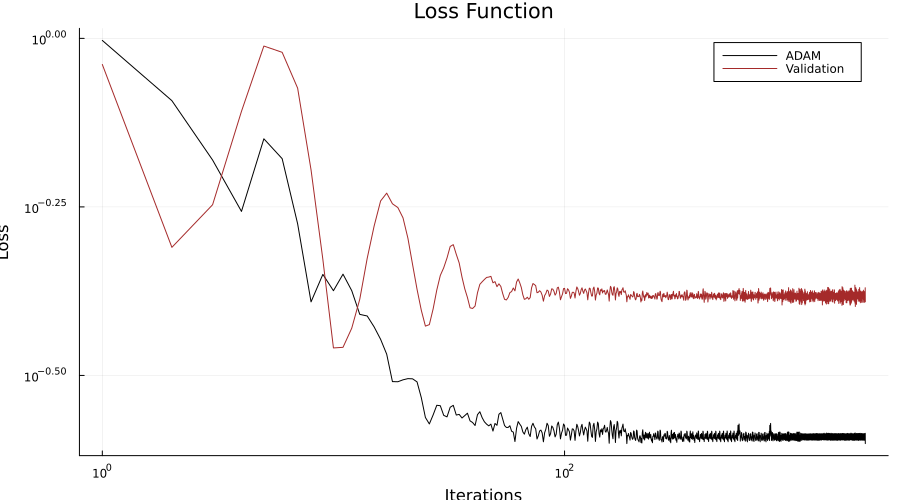

In [24]:
# Plot losses

default(size = (900, 500));
plot(
    1:loss_adam_end, losses[1:loss_adam_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "ADAM", color = :black,
    title = "Loss Function"
);

plot!(
    1:lossval_adam_end, val_losses[1:lossval_adam_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "Validation", color = :brown,
    title = "Loss Function"
);

xlabel!("Iterations")
ylabel!("Loss")

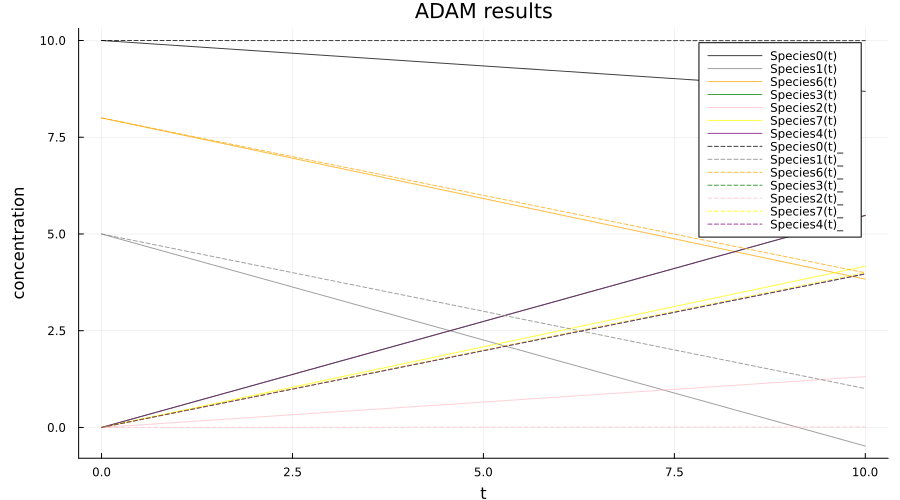

In [25]:
# Plot the trained model
tp = res1.minimizer;
X3 = Array(FWmodule.predict(tp, prob_nn, method, abstol, reltol, saveat));

default(size = (900, 500))
plot(
    t, 
    X'[:, selected_species],
    title = "ADAM results",
    alpha=0.75, 
    labels=permutedims(speciesvector),
    ls=permutedims([:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid]),
    color=permutedims([:black, :grey, :orange, :green, :pink, :yellow, :purple, :brown, :blue, :red])
)

xlabel!("t")
ylabel!("concentration")
speciesvector2_ = [string(s)*"_" for s in speciesvector2]
plot!(
    t, 
    X3',
    alpha=0.75,
    labels=permutedims(speciesvector2_),
    ls=:dash,
    color=permutedims([:black, :grey, :orange, :green, :pink, :yellow, :purple, :brown, :blue, :red]),
    left_margin=5Plots.mm
)

In [26]:
# Obtenha os índices de tempo correspondentes aos momentos desejados
momentos_desejados = [1, 5, 10]
indices_momentos = [findmin(abs.(t .- momento))[2] for momento in momentos_desejados]

# Print species values in moments 5, 10 and 20
for i in selected_species
    println("Espécie: ", speciesvector[i])
    for j in 1:length(momentos_desejados)
        momento = momentos_desejados[j]
        indice = indices_momentos[j]
        valor = X[i, indice]
        println("Tempo ", momento, ": ", valor)
    end
    println()
end

Espécie: Species0(t)
Tempo 1: 9.8686274706504
Tempo 5: 9.343137367447738
Tempo 10: 8.686274704685925

Espécie: Species1(t)
Tempo 1: 4.451960789306487
Tempo 5: 2.2598040057519544
Tempo 10: -0.4803921145195371

Espécie: Species6(t)
Tempo 1: 7.583333333557247
Tempo 5: 5.916666712810022
Tempo 10: 3.8333333298061536

Espécie: Species3(t)
Tempo 1: 0.5480392106935121
Tempo 5: 2.7401959942480456
Tempo 10: 5.480392114519537

Espécie: Species2(t)
Tempo 1: 0.13137252934959873
Tempo 5: 0.6568626325522621
Tempo 10: 1.3137252953140757

Espécie: Species7(t)
Tempo 1: 0.41666666644275197
Tempo 5: 2.0833332871899777
Tempo 10: 4.1666666701938455

Espécie: Species4(t)
Tempo 1: 0.5480392106935121
Tempo 5: 2.7401959942480456
Tempo 10: 5.480392114519537



In [27]:
# Obtenha os índices de tempo correspondentes aos momentos desejados
momentos_desejados = [1, 5, 10]
indices_momentos = [findmin(abs.(t .- momento))[2] for momento in momentos_desejados]

# Print species values in moments 5, 10 and 20
for i in selected_species2
    println("Espécie: ", speciesvector2[i])
    for j in 1:length(momentos_desejados)
        momento = momentos_desejados[j]
        indice = indices_momentos[j]
        valor = X3[i, indice]
        println("Tempo ", momento, ": ", valor)
    end
    println()
end

Espécie: Species0(t)
Tempo 1: 9.99967664649414
Tempo 5: 9.998383227366883
Tempo 10: 9.9967664511424

Espécie: Species1(t)
Tempo 1: 4.600556888731712
Tempo 5: 3.0027845035737175
Tempo 10: 1.0055690457231041

Espécie: Species6(t)
Tempo 1: 7.599680256831711
Tempo 5: 5.99840133121263
Tempo 10: 3.996802692305031

Espécie: Species3(t)
Tempo 1: 0.3968119531690108
Tempo 5: 1.9840597265402573
Tempo 10: 3.968119429578293

Espécie: Species2(t)
Tempo 1: 0.0012200180015168106
Tempo 5: 0.006100096409274598
Tempo 10: 0.012200197708530796

Espécie: Species7(t)
Tempo 1: 0.400101506654192
Tempo 5: 2.0005074745052256
Tempo 10: 4.001014911159699

Espécie: Species4(t)
Tempo 1: 0.39696593046606315
Tempo 5: 1.9848295975507673
Tempo 10: 3.9696591596599853



# SGD Method

In [28]:
mdl3 = FWmodule.import_sbml("cutmodel.sbml", 2, 4)
rs3, odesys3, reactionsvector3, speciesvector3, ode_func3 = FWmodule.define_model(mdl3);
u0_3 = zeros(7)
u0_3[1] = 10.0;      # Species0
u0_3[2] = 5.0;       # Species1 
u0_3[3] = 8.0;       # Species6
u0_3[4] = 0.0;       # Species3
u0_3[5] = 0.0;       # Species2
u0_3[6] = 0.0;       # Species7
u0_3[7] = 0.0;      # Species4

selected_species3 = [1, 2, 3, 4, 5, 6, 7];
len_param3 = length(reactionparams(rs3))
paramsvector3 = reactionparams(rs3)[1:len_param3-1]
model_param3 = Float32.([0.1, 0.2, 0.5]);

tspan3 = (0.0f0, 10.0f0);
method3 = Rosenbrock23();
abstol3= 1e-12; reltol3=1e-6; saveat3 = 0.1;
X_3, t_3 = FWmodule.gen_timeseries(tspan3, odesys3, u0_3, model_param3, method3, abstol3, reltol3, saveat3);

# Defining the neural network characteristics
rng3 = Random.default_rng(12345)

U3 = Lux.Chain(
    Lux.Dense(7, 7, Lux.sigmoid),   
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7, Lux.sigmoid),
    Lux.Dense(7, 7)                 
)

nn_p3, nn_st3 = Lux.setup(rng3, U3);

# Converting to UDE's
nn_dynamics3!(du, u, p, t) = FWmodule.ude_dynamics!(du, u, model_param3, p, nn_st3, t_3, ode_func3, U3)

# Generating predict and loss functions parameters
prob_nn3 = ODEProblem(nn_dynamics3!, u0_3, tspan3, nn_p3);
method3 = AutoVern7(Rodas4())
abstol3=1e-6; reltol3=1e-6; saveat3 = 0.1;
X_val3 = view(X_3, :, 1:50)
N3 = size(X_3)[2]
X_train3 = view(X_3, :, 51:N3)
N_val3 = size(X_val3)[2]
N_train3 = size(X_train3)[2]
_step3 = 1
val_losses3 = Float32[];

callback3(θ,l3) = begin # Callback to show the loss during training
    push!(losses3, l3)
    println(IJulia.orig_stdout[], "Current loss after $(length(losses3)) iterations: $(losses3[end])")

    # Evaluate the model on the validation set
    val_loss3 = FWmodule.loss(θ, prob_nn3, method3, abstol3, reltol3, saveat3, N_val3, X_val3, _step3, selected_species3)
    push!(val_losses3, val_loss3)
    println(IJulia.orig_stdout[], "Current validation loss after $(length(val_losses3)) iterations: $(val_losses3[end])")

    false
end

┌ Warning: SBMLToolkit currently fires events regardless of uppass or downpass trigger.
└ @ SBMLToolkit C:\Users\marce\.julia\packages\SBMLToolkit\L2qXg\src\events.jl:28


callback3 (generic function with 1 method)

In [29]:
# Train with SGD
losses3 = Float32[];
maxiters3 = 2000;

adtype3 = Optimization.AutoForwardDiff()
optf3 = Optimization.OptimizationFunction((x,p)->(FWmodule.loss(x, prob_nn3, method3, abstol3, reltol3, saveat3, N_train3, X_train3, _step3, selected_species3)), adtype3)
optprob3 = Optimization.OptimizationProblem(optf3, ComponentVector{Float64}(nn_p3))

res3 = Optimization.solve(
    optprob3,
    GradientDescent(),
    maxiters=maxiters3,
    callback=callback3,
    progress=true
)

loss_sgd_end = size(losses3)[1];
println("Training loss after $(length(losses3)) iterations: $(losses3[end])");
lossval_sgd_end = size(val_losses3)[1]
println("Validation loss after $(length(val_losses3)) iterations: $(val_losses3[end])");

Training loss after 2001 iterations: 0.24890198
Validation loss after 2001 iterations: 0.406703


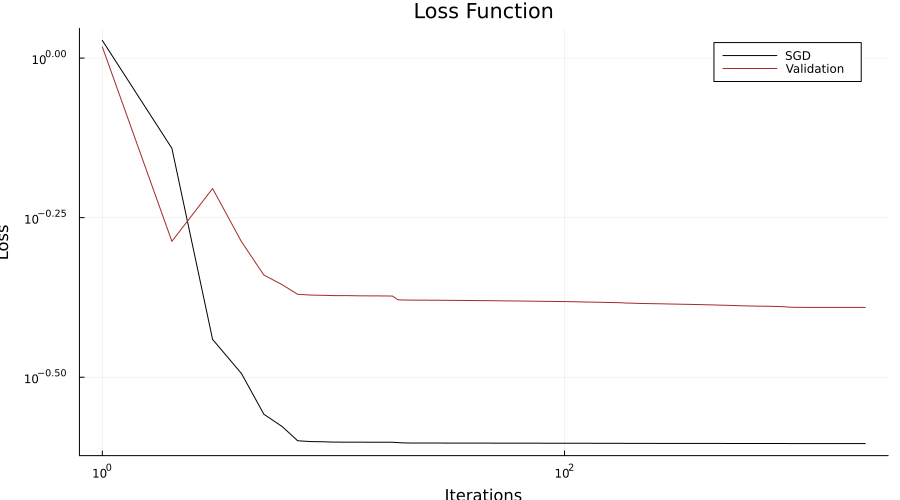

In [30]:
# Plot losses

default(size = (900, 500));
plot(
    1:loss_sgd_end, losses3[1:loss_sgd_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "SGD", color = :black,
    title = "Loss Function"
);

plot!(
    1:lossval_sgd_end, val_losses3[1:lossval_sgd_end], 
    yaxis = :log10, xaxis = :log10, 
    label = "Validation", color = :brown,
    title = "Loss Function"
);

xlabel!("Iterations")
ylabel!("Loss")

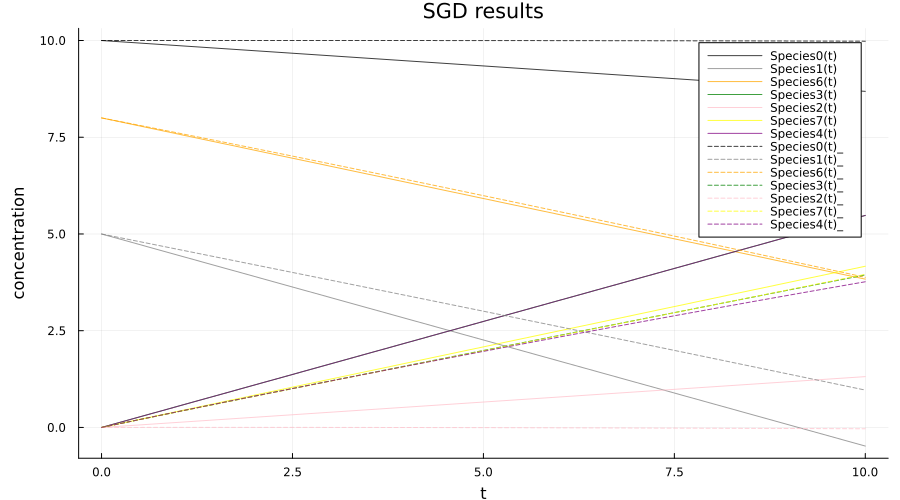

In [31]:
# Plot the trained model
tp3 = res3.minimizer;
X33 = Array(FWmodule.predict(tp3, prob_nn3, method3, abstol3, reltol3, saveat3));

default(size = (900, 500))
plot(
    t, 
    X'[:, selected_species],
    title = "SGD results",
    alpha=0.75, 
    labels=permutedims(speciesvector3),
    ls=permutedims([:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid,:solid]),
    color=permutedims([:black, :grey, :orange, :green, :pink, :yellow, :purple, :brown, :blue, :red])
)

xlabel!("t")
ylabel!("concentration")
speciesvector3_ = [string(s)*"_" for s in speciesvector3]
plot!(
    t, 
    X33',
    alpha=0.75,
    labels=permutedims(speciesvector3_),
    ls=:dash,
    color=permutedims([:black, :grey, :orange, :green, :pink, :yellow, :purple, :brown, :blue, :red]),
    left_margin=5Plots.mm
)

In [32]:
# Obtenha os índices de tempo correspondentes aos momentos desejados
momentos_desejados = [1, 5, 10]
indices_momentos = [findmin(abs.(t .- momento))[2] for momento in momentos_desejados]

# Print species values in moments 5, 10 and 20
for i in selected_species3
    println("Espécie: ", speciesvector3[i])
    for j in 1:length(momentos_desejados)
        momento = momentos_desejados[j]
        indice = indices_momentos[j]
        valor = X33[i, indice]
        println("Tempo ", momento, ": ", valor)
    end
    println()
end

Espécie: Species0(t)
Tempo 1: 9.999999997939533
Tempo 5: 9.999018496058465
Tempo 10: 9.982257528444652

Espécie: Species1(t)
Tempo 1: 4.603355970636373
Tempo 5: 3.0045194546987264
Tempo 10: 0.965979744587534

Espécie: Species6(t)
Tempo 1: 7.6105332327420365
Tempo 5: 5.991081459580519
Tempo 10: 3.880394296487511

Espécie: Species3(t)
Tempo 1: 0.4059953582683566
Tempo 5: 1.9902846544732866
Tempo 10: 3.9422590921811738

Espécie: Species2(t)
Tempo 1: 0.002450111212966261
Tempo 5: -0.004748961878507546
Tempo 10: -0.034007145528573875

Espécie: Species7(t)
Tempo 1: 0.40446789107111
Tempo 5: 1.9820957539679787
Tempo 10: 3.9574649517529186

Espécie: Species4(t)
Tempo 1: 0.408674907447192
Tempo 5: 1.9662626221503863
Tempo 10: 3.7655108412939624



### Model Selection

In [33]:
# Calculate solutions numerically
sol_nn = solve(prob_nn, method2, abstol=abstol2, reltol=reltol2, saveat=saveat2)
sol_sgd_nn = solve(prob_nn3, method3, abstol=abstol3, reltol=reltol3, saveat=saveat3)


# Calculate metrics for the trained model and the traditional SBML model
best_model = FWmodule.calculate_metrics(sol_nn, sol_sgd_nn, X_2, nn_p, model_param)

# Shows the selected model
best_model

"m1"

In [34]:
# Parte 1: Cálculo do MAE
mae_nn1 = FWmodule.calculate_mae(Array(sol_nn), X)
mae_nn2 = FWmodule.calculate_mae(Array(sol_sgd_nn), X)
        if mae_nn1 > mae_nn2
            best_mae = "Model 2"
        else
            best_mae = "Model 1"
        end

# Parte 2: Cálculo do R²
r2_nn1 = FWmodule.calculate_r2(Array(sol_nn), X)
r2_nn2 = FWmodule.calculate_r2(Array(sol_sgd_nn), X)
        if r2_nn1 > r2_nn2
            best_r2 = "Model 1"
        else
            best_r2 = "Model 2"
        end

# Parte 3: Cálculo do BIC
num_parameters_nn1 = length(nn_p)
num_parameters_nn2 = length(model_param)
num_data_points = length(X)
bic_nn1 = FWmodule.calculate_bic(Array(sol_nn), X, num_parameters_nn1, num_data_points)
bic_nn2 = FWmodule.calculate_bic(Array(sol_sgd_nn), X, num_parameters_nn2, num_data_points)
        if bic_nn1 > bic_nn2
            best_bic = "Model 2"
        else
            best_bic = "Model 1"
        end

combined_score_nn1 = r2_nn1 - mae_nn1 - bic_nn1
combined_score_nn2 = r2_nn2 - mae_nn2 - bic_nn2
        if combined_score_nn1 > combined_score_nn1
            best_model = "Model 1"
        else
            best_model = "Model 2"
        end

# Print the results
println("Metrics for Model 1:")
println("MAE: ", mae_nn1)
println("R²: ", r2_nn1)
println("BIC: ", bic_nn1)
println()
println("Metrics for Model 2:")
println("MAE: ", mae_nn2)
println("R²: ", r2_nn2)
println("BIC: ", bic_nn2)
println()
println("Best model R2: ", best_r2)
println("Best model MAE: ", best_mae)
println("Best model BIC: ", best_bic)
println()
println("Metrics for model 1: ", combined_score_nn1)
println("Metrics for model 2: ", combined_score_nn2)
println("Best model in general: ", best_model)

Metrics for Model 1:
MAE: 1.9258014879493555
R²: 0.2380688860396103
BIC: 1392.4757558858862

Metrics for Model 2:
MAE: 2.0131830371992114
R²: 0.04149101084638884
BIC: 1567.8704303300306

Best model R2: Model 1
Best model MAE: Model 1
Best model BIC: Model 1

Metrics for model 1: -1394.163488487796
Metrics for model 2: -1569.8421223563835
Best model in general: Model 2
